# Background
Banks earn major revenue from lending loans, but this activity also brings risk as borrowers might default on their loan. To mitigate this, banks are leveraging Artificial Intelligence (AI) and Machine Learning (ML) to help predict how likely a borrower is to repay a loan. While this approach can lead to higher returns, banks must be careful when utilizing AI & ML for credit approval decisions due to the presence of bias in training data.

For this project, I looked at the impact of using biased data that could be used to train algorithms associated with learning from credit-based data sets. I took a loan approval dataset and used industry-defined fairness metrics to assess whether bias was present in the data. I then applied bias-mitigating techniques to produce a dataset without bias.

Identifying and mitigating bias within training data is necessary for AI applications for several reasons:

1. Fairness: Today, AI applications are increasingly being used to make decisions that have a significant impact on people's lives, such as hiring, loan approvals, and parole decisions. If these applications are biased, they can unfairly discriminate against certain groups of people, leading to unjust outcomes.

2. Accuracy: Inaccuracies in the predictions or recommendations generated by algorithm is another potential consequence of bias in AI applications. For example, if an AI algorithm is trained on biased data, it may make inaccurate predictions for individuals who don't fit the majority pattern in the data.

3. Ethics: Discrimination and marginalization of underrepresented groups can perpetuate if AI applications contain bias. Mitigating bias is therefore an ethical imperative, as it helps ensure that AI is used in ways that are consistent with social and moral values.

4. Trust: Bias can erode trust in AI applications, as users may be wary of using an algorithm that produces biased outcomes. By mitigating bias, AI developers can build trust in their applications and encourage greater adoption and usage.

Overall, taking steps to mitigate bias is necessary to ensure that AI applications are fair, accurate, ethical, and trustworthy. This is essential for building AI systems that benefit society as a whole, rather than perpetuating existing inequalities and injustices.

## Step 1: Selecting a Dataset
I selected a Loan Default Dataset from Kaggle uploaded by M YASSER H in 2022. This dataset concerns credit card application decisions, and is interesting for AI & ML applications because there's a good mix of attributes -- continuous, nominal with a narrow range of values, and nominal with a wide range of values -- and it is subject to strong multi-collinearity & empty values. Of particular interest to me was the fact that this dataset also contained several protected class variables. For this project, I examined whether bias was present when looking at outcomes for 'rate_of_interest' and 'status' associated with different values for 'age' and 'gender' protected clasess.

The 'loan_data.csv' used in this project contains a random sample of 10% of the original Loan Default Dataset.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset


df = pd.read_csv(r"Data\loan_data.csv")
pd.options.mode.chained_assignment = None
df.head(10)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,169817,2019,NaN,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,CRIF,579,CIB,65-74,to_inst,80.963303,south,direct,0,47.0
1,55084,2019,NaN,Male,nopre,type1,p3,l1,nopc,nob/c,...,CIB,721,CIB,25-34,to_inst,39.016736,south,direct,0,49.0
2,168883,2019,cf,Female,pre,type1,p1,l1,nopc,nob/c,...,EQUI,702,EXP,25-34,to_inst,NaN,North,direct,1,NaN
3,169509,2019,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,...,EQUI,525,EXP,35-44,not_inst,NaN,North,direct,1,NaN
4,41829,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,CIB,557,CIB,55-64,to_inst,83.730159,North,direct,0,40.0
5,90384,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,CRIF,899,CIB,65-74,not_inst,58.561644,south,direct,0,26.0
6,67227,2019,cf,Sex Not Available,pre,type1,p3,l1,nopc,nob/c,...,CIB,616,CIB,<25,not_inst,37.092391,south,direct,0,45.0
7,30443,2019,cf,Sex Not Available,nopre,type1,p3,l2,nopc,nob/c,...,EQUI,613,EXP,55-64,to_inst,NaN,south,direct,1,NaN
8,52136,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,647,CIB,35-44,not_inst,94.597990,North,direct,0,47.0
9,131441,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,500,EXP,45-54,not_inst,73.471616,North,direct,1,60.0


I first cleaned up the data set. This made it easier to work with as I moved through the bias-identification analysis.

In [111]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

# Make ID string type
df['id'] = df['id'].astype(str)

# Drop year since all entries are 2019
df.drop(columns=['year'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         14770 non-null  object 
 1   loan_limit                 14452 non-null  object 
 2   gender                     14770 non-null  object 
 3   approv_in_adv              14694 non-null  object 
 4   loan_type                  14770 non-null  object 
 5   loan_purpose               14755 non-null  object 
 6   credit_worthiness          14770 non-null  object 
 7   open_credit                14770 non-null  object 
 8   business_or_commercial     14770 non-null  object 
 9   loan_amount                14770 non-null  int64  
 10  rate_of_interest           11202 non-null  float64
 11  interest_rate_spread       11173 non-null  float64
 12  upfront_charges            10891 non-null  float64
 13  term                       14764 non-null  flo

Next, I checked for null values and properly handled those before going any further.

In [112]:
# Check for missing values in the DataFrame
null_columns = df.columns[df.isnull().any()]
print("Number of null values per attribute:")
print(df[null_columns].isnull().sum())

Number of null values per attribute:
loan_limit                    318
approv_in_adv                  76
loan_purpose                   15
rate_of_interest             3568
interest_rate_spread         3597
upfront_charges              3879
term                            6
neg_ammortization              12
property_value               1512
income                        891
age                            29
submission_of_application      29
ltv                          1512
dtir1                        2392
dtype: int64


There were quite a few columns with null values. I then went down the list and start handling them properly.

In [113]:
# Getting dataframes by datatype
data_types = pd.DataFrame(df.dtypes).reset_index()

categorical_vars = []
numerical_vars = []
for i, l in zip(data_types['index'], data_types[0]):
    if l == 'object':
        categorical_vars.append(i)
    else:
        numerical_vars.append(i)

I started with the numerical data first. One of the best methods for replacing Null values for numerical data is using a KNNImputer from sklearn. I could have replaced the Null values using the column median or mean, but KNNImputer uses the n-number of neighbor-columns that have values (at that index) to estimate the null value of a certain entry. In this example, I used 2 neighbors. This method produces a more "realistic" substitution of values.

In [114]:
# Numeric Dataframe
df_num = df[numerical_vars]

# knn
knn = KNNImputer(n_neighbors = 2)
knn.fit(df_num)
X = knn.fit_transform(df_num)

# Check for any nas
df_num = pd.DataFrame(X, columns=numerical_vars)

Next I handled the categorical data with Null values. Here, I took the modal value for each column. Once all Null values were imputed, I concatenated the numeric and categorical dataframes.

In [115]:
# Categorical Dataframe
df_cat = df[categorical_vars]

for i in categorical_vars:
    mode = df[i].mode()
    mode = mode[0]
    df_cat[i].fillna(value=mode, inplace=True)

# Combining dataframes
df_new = pd.concat([df_num, df_cat], axis=1, join='inner')
print(df_new.isna().sum())
print("Pre-processed dataset")
df_new.head(10)

loan_amount                  0
rate_of_interest             0
interest_rate_spread         0
upfront_charges              0
term                         0
property_value               0
income                       0
credit_score                 0
ltv                          0
status                       0
dtir1                        0
id                           0
loan_limit                   0
gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
credit_worthiness            0
open_credit                  0
business_or_commercial       0
neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
region                       0
security

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,property_value,income,credit_score,ltv,status,...,construction_type,occupancy_type,secured_by,total_units,credit_type,co-applicant_credit_type,age,submission_of_application,region,security_type
0,176500.0,3.2500,0.39970,4100.000,180.0,218000.0,3600.0,579.0,80.963303,0.0,...,sb,pr,home,1U,CRIF,CIB,65-74,to_inst,south,direct
1,186500.0,3.6250,0.45090,1067.200,180.0,478000.0,3180.0,721.0,39.016736,0.0,...,sb,pr,home,1U,CIB,CIB,25-34,to_inst,south,direct
2,346500.0,3.3750,-0.37195,2299.640,360.0,388000.0,7500.0,702.0,91.491997,1.0,...,sb,pr,home,1U,EQUI,EXP,25-34,to_inst,North,direct
3,446500.0,3.4375,-0.16400,1941.170,360.0,658000.0,7680.0,525.0,71.074646,1.0,...,sb,pr,home,1U,EQUI,EXP,35-44,not_inst,North,direct
4,316500.0,4.5000,0.16790,1150.000,360.0,378000.0,7800.0,557.0,83.730159,0.0,...,sb,pr,home,1U,CIB,CIB,55-64,to_inst,North,direct
5,256500.0,4.3750,0.00500,1495.000,360.0,438000.0,8160.0,899.0,58.561644,0.0,...,sb,pr,home,1U,CRIF,CIB,65-74,not_inst,south,direct
6,136500.0,4.7500,0.40210,375.200,360.0,368000.0,3180.0,616.0,37.092391,0.0,...,sb,pr,home,1U,CIB,CIB,<25,not_inst,south,direct
7,96500.0,4.1825,0.70165,2209.635,300.0,118000.0,1020.0,613.0,82.371238,1.0,...,sb,pr,home,1U,EQUI,EXP,55-64,to_inst,south,direct
8,376500.0,4.2500,0.29160,0.000,360.0,398000.0,4980.0,647.0,94.597990,0.0,...,sb,pr,home,1U,CIB,CIB,35-44,not_inst,North,direct
9,336500.0,4.0625,0.43205,7584.095,360.0,458000.0,5400.0,500.0,73.471616,1.0,...,sb,pr,home,1U,EXP,EXP,45-54,not_inst,North,direct


## Step 2: Segmenting Based on Protected Class and Dependent Variables

### 2.1
For this exercise, I identified  members associated with my protected class variables, 'age' and 'gender', and grouped them together into a subset of membership categories.

First, I checked the unique values for my variables to determine if they needed to be grouped into subcategories.

In [116]:
# select two specific columns
cols = ['age', 'gender']

# print the unique values for the selected columns in table format
for col in cols:
    print(f'Unique values and frequency count for {col}:')
    print(df_new[col].value_counts().sort_index())
    print('\n')
    print(f'The mode for {col} is ' + df_new[col].mode())
    print('\n')

Unique values and frequency count for age:
25-34    1901
35-44    3298
45-54    3496
55-64    3184
65-74    2095
<25       142
>74       654
Name: age, dtype: int64


0    The mode for age is 45-54
Name: age, dtype: object


Unique values and frequency count for gender:
Female               2755
Joint                4043
Male                 4159
Sex Not Available    3813
Name: gender, dtype: int64


0    The mode for gender is Male
Name: gender, dtype: object




Based on the values, I decided to group 'age' because it had 7 unique values whereas 'gender' had only four unique values.

I created a new field 'derived_age' to discretize the values of 'age'. Since the values for 'age' spanned from <25 to >74, I used the discrete categories "Young", "Middle-Aged", and "Old", to represent the 'age' values from 0 to 34, 35 to 54, and 55+, respectively.

After creating the new field, I generated a table documenting the relationship between members and membership categories for the 'age' and 'derived_age' protected class variables. Since I left 'gender' unchanged, I didn't generate a table for that protect class variable.

In [117]:
# Define the conditions and corresponding values for the derived_age column
conditions = [(df_new['age'] == '<25') | (df_new['age'] == '25-34'),
              (df_new['age'] == '35-44') | (df_new['age'] == '45-54'),
              (df_new['age'] == '55-64') | (df_new['age'] == '65-74') | (df_new['age'] == '>74')]

values = ['Young', 'Middle-Aged', 'Old']

# Apply the conditions and values to the derived_age column using numpy.select()
df_new['derived_age'] = np.select(conditions, values)

In [118]:
# Create a cross-tabulation table of derived_age and age
ct = pd.crosstab(df_new['derived_age'], df_new['age'])
ct = ct.loc[values]

# Print the table
print(ct)

age          25-34  35-44  45-54  55-64  65-74  <25  >74
derived_age                                             
Young         1901      0      0      0      0  142    0
Middle-Aged      0   3298   3496      0      0    0    0
Old              0      0      0   3184   2095    0  654


### 2.2
Next, I discretized the values associated with my dependent variables into categories/numerical values, as appropriate. Again, I first checked the unique values for 'rate_of_interest' and 'status' to determine if they needed to be grouped into subcategories.

In [119]:
# select two specific columns
cols = ['rate_of_interest', 'status']

# print the unique values for the selected columns in table format
for col in cols:
    print(f'Unique values and frequency count for {col}:')
    print(df_new[col].value_counts().sort_index())
    print('\n')

Unique values and frequency count for rate_of_interest:
2.2500     1
2.4750     1
2.5750     1
2.7500    71
2.8125     6
          ..
6.1250     1
6.2400    23
6.2500     1
6.5000     1
7.5000     1
Name: rate_of_interest, Length: 208, dtype: int64


Unique values and frequency count for status:
0.0    11173
1.0     3597
Name: status, dtype: int64




Based on the values, I grouped 'rate_of_interest', but not 'status' - 'rate_of_interest' had dozens of unique values whereas 'status' had only two unique values.

First, I created a new field 'derived_interest' to discretize the values of 'rate_of_interest'. Since the values for 'rate_of_interest' span from 0 to 8, I used the discrete categories "Low", "Med-Low", "Med-High", and "High" to represent 'rate_of_interest' values from 0 to 3, 3 to 4, 4 to 5, and 5+, respectively.

After creating the new field, I generated a table documenting the frequency of and relationship between members and membership categories for the 'rate_of_interest' and 'derived_interest' dependent variables. Since I left 'status' unchanged, I didn't generate a table for that dependent variable.

In [120]:
# Define the conditions and corresponding values for the derived_interest column
conditions = [df_new['rate_of_interest'] < 3,
    (df_new['rate_of_interest'] >= 3) & (df_new['rate_of_interest'] < 4),
    (df_new['rate_of_interest'] >= 4) & (df_new['rate_of_interest'] < 5),
    (df_new['rate_of_interest'] >= 5)]

values = ['Low', 'Med-Low', 'Med-High', 'High']

# Apply the conditions and values to the derived_interest column using numpy.select()
df_new['derived_interest'] = np.select(conditions, values)

# Create a cross-tabulation table of derived_interest and rate_of_interest
ct = pd.crosstab(df_new['derived_interest'], df_new['rate_of_interest'])
ct = ct.T
print(ct)

derived_interest  High  Low  Med-High  Med-Low
rate_of_interest                              
2.2500               0    1         0        0
2.4750               0    1         0        0
2.5750               0    1         0        0
2.7500               0   71         0        0
2.8125               0    6         0        0
...                ...  ...       ...      ...
6.1250               1    0         0        0
6.2400              23    0         0        0
6.2500               1    0         0        0
6.5000               1    0         0        0
7.5000               1    0         0        0

[208 rows x 4 columns]


### 2.3
 I then generated frequency tables for the protected class and dependent variables to make sure there were sufficient values for analysis.

In [121]:
# Select specific columns
cols = ['status', 'derived_interest', 'gender', 'derived_age']

# define the desired sort order
interest_sort_order = ['Low', 'Med-Low', 'Med-High', 'High']
age_sort_order = ['Young', 'Middle-Aged', 'Old']
gender_sort_order = ['Male', 'Female', 'Joint', 'Sex Not Available']

# print the unique values for the selected columns in table format
for col in cols:
    print(f'Unique values and frequency count for {col}:')
    if col == 'derived_interest':
        print(df_new[col].value_counts().reindex(interest_sort_order))
    elif col == 'derived_age':
        print(df_new[col].value_counts().reindex(age_sort_order))
    elif col == 'gender':
        print(df_new[col].value_counts().reindex(gender_sort_order))
    else:
        print(df_new[col].value_counts().sort_index())
    print('\n')

Unique values and frequency count for status:
0.0    11173
1.0     3597
Name: status, dtype: int64


Unique values and frequency count for derived_interest:
Low          366
Med-Low     8132
Med-High    5872
High         400
Name: derived_interest, dtype: int64


Unique values and frequency count for gender:
Male                 4159
Female               2755
Joint                4043
Sex Not Available    3813
Name: gender, dtype: int64


Unique values and frequency count for derived_age:
Young          2043
Middle-Aged    6794
Old            5933
Name: derived_age, dtype: int64




### 2.4
Next, I created histograms for each protected class variable that graphs the relative proportions of values of its membership categories as a function of the dependent variables. For this exercise I used the discrete transformations for each of the protected and dependent variables.

This exercise helped me visualize the data and identify areas of potential bias.

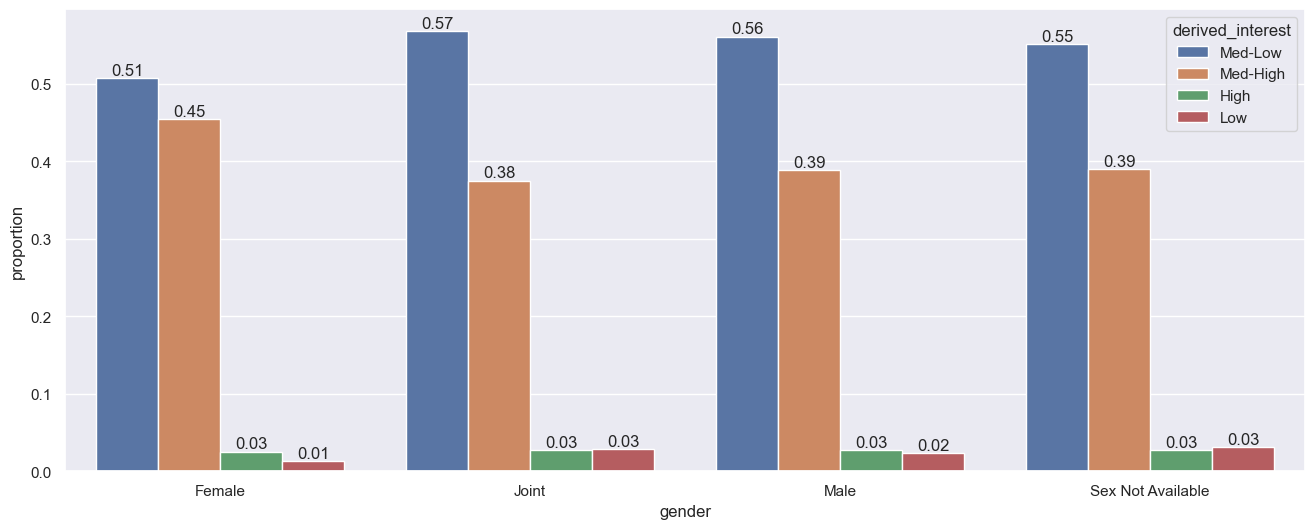

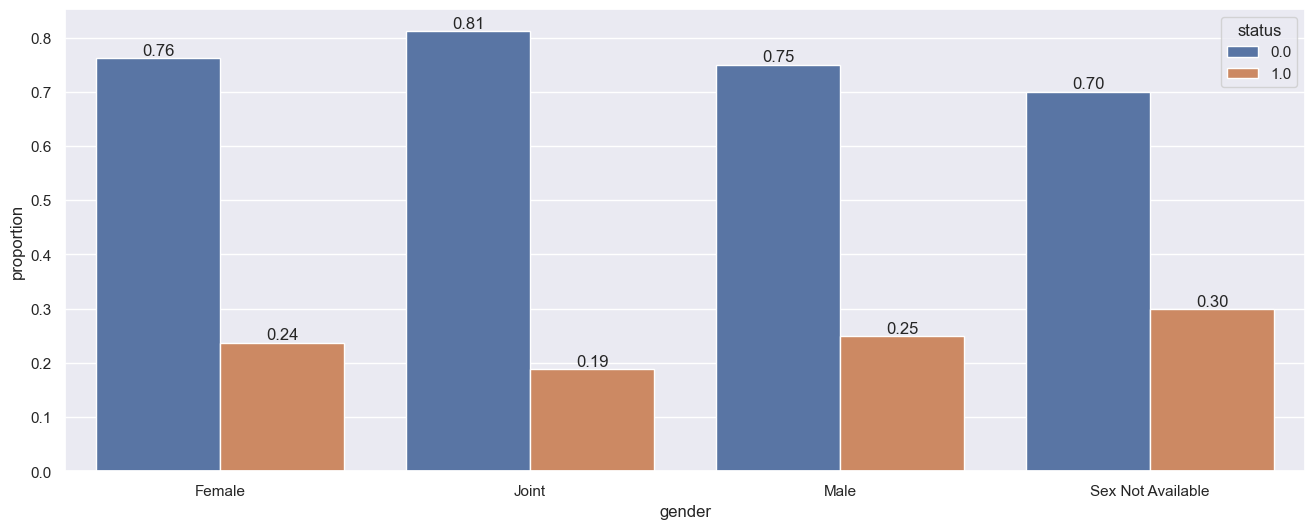

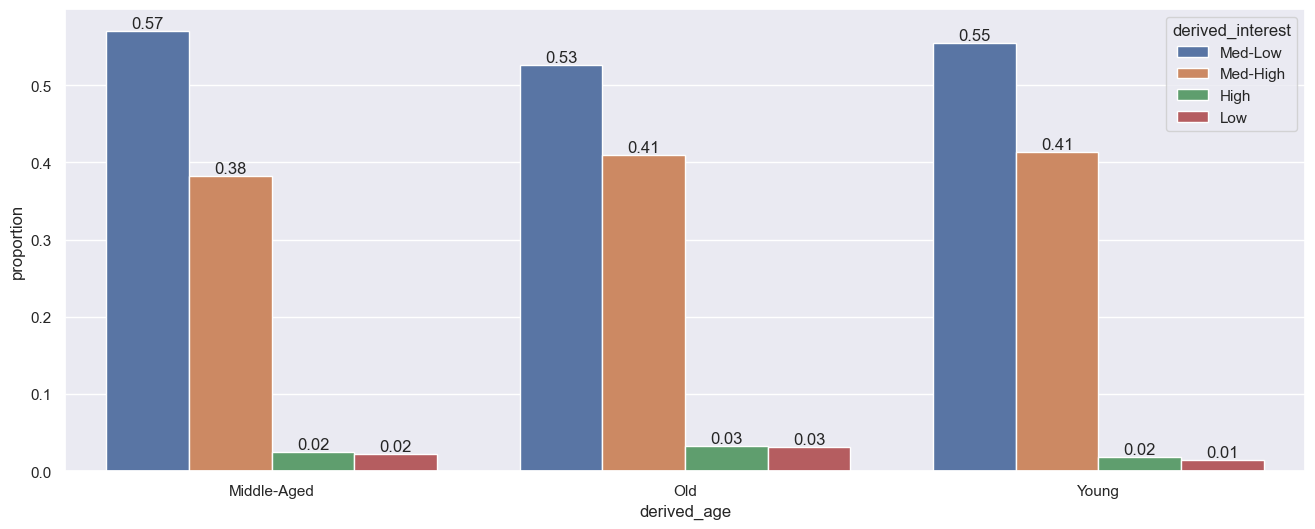

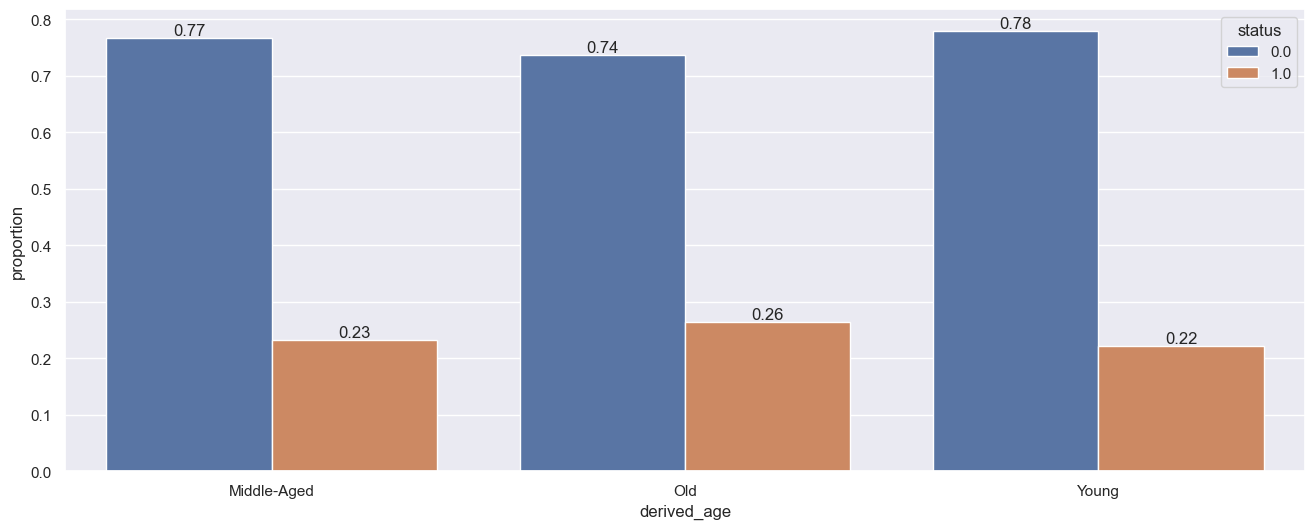

In [122]:
%matplotlib inline
# Histograms
protected = ['gender', 'derived_age']

for i in protected:
    plt.figure(figsize=(16, 6))
    sns.set_theme(style='darkgrid')

    # Calculate the proportions relative to 'derived_interest'
    interest_proportions = df_new.groupby(i)['derived_interest'].value_counts(normalize=True).reset_index(name='proportion')

    ax = sns.barplot(data=interest_proportions, x=i, y='proportion', hue="derived_interest")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.set_theme(style='darkgrid')

    # Calculate the proportions relative to 'statue'
    status_proportions = df_new.groupby(i)['status'].value_counts(normalize=True).reset_index(name='proportion')

    ax = sns.barplot(data=status_proportions, x=i, y='proportion', hue="status")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.show()

From the histograms, it was hard to tell whether any bias was present. To be sure, I used industry-recognized bias metrics to further examine the data.

## Step 3: Applying Fairness Metrics

### 3.1
For this exercise, I started by identifying the privileged/unprivileged groups associated with each of my protected class variables, as well as the favorable/unfavorable outcomes associated with each of my dependent variables:

Protected Class Variables:
'derived_age':
* privileged:   'Young'
* unprivileged: 'Middle-Aged', 'Old'

'gender':
* privileged: 'Male'
* unprivileged: 'Female', 'Joint', 'Sex Not Available'

### 3.2
For each protected class variable, I selected two fairness metrics and compute the fairness metrics associated with my privileged/unprivileged groups as a function of each of my two dependent variables.
To do this, I first assigned a reasonable threshold to each dependent variable in order to generate a baseline for comparison using the fairness metrics.

Dependent Variables:
'derived_interest':
* favorable:   'Low'
* unfavorable: 'Med-Low', 'Med-High', 'High'

'status':
* favorable:   0
* unfavorable: 1

The two fairness metrics I used were Statistical Parity Difference and Disparate Impact.

To compute the Statistical Parity Difference, I computed the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. Fairness for this metric was between -0.1 and 0.1.

In [123]:
# Statistical Parity Difference function
def spd(data, protected_var, dependent_var, privileged_group, unprivileged_groups, favorable_outcome):


    privileged_rate = data[(data[protected_var] == privileged_group) & (data[dependent_var] == favorable_outcome)][dependent_var].count() / data[data[protected_var] == privileged_group][dependent_var].count()

    unprivileged_rate = data[(data[protected_var].isin(unprivileged_groups)) & (data[dependent_var] == favorable_outcome)][dependent_var].count() / data[data[protected_var].isin(unprivileged_groups)][dependent_var].count()

    return unprivileged_rate - privileged_rate

# Assigning baseline thresholds for each dependent variable
interest_threshold = 'Low'
status_threshold = 0

# Computing SPD for derived_age
derived_age_privileged = 'Old'
derived_age_unprivileged = ['Middle-Aged', 'Young']

spd_derived_age_interest = spd(df_new, 'derived_age', 'derived_interest', derived_age_privileged, derived_age_unprivileged, interest_threshold)

spd_derived_age_status = spd(df_new, 'derived_age', 'status', derived_age_privileged, derived_age_unprivileged, status_threshold)

# Computing SPD for gender
gender_privileged = 'Joint'
gender_unprivileged = ['Female', 'Male', 'Sex Not Available']

spd_gender_interest = spd(df_new, 'gender', 'derived_interest', gender_privileged, gender_unprivileged, interest_threshold)

spd_gender_status = spd(df_new, 'gender', 'status', gender_privileged, gender_unprivileged, status_threshold)

spd_values = {
    'Original Dataset SPD': {
        'derived_age and derived_interest': spd_derived_age_interest,
        'derived_age and status': spd_derived_age_status,
        'gender and derived_interest': spd_gender_interest,
        'gender and status': spd_gender_status,
    }
}

spd_df = pd.DataFrame(spd_values)

print(spd_df)

                                  Original Dataset SPD
derived_age and derived_interest             -0.010981
derived_age and status                        0.033555
gender and derived_interest                  -0.005726
gender and status                            -0.076153


The Statistical Parity Difference values looked good. Next, I looked at the Disparate Impact values.

To compute the Disparate Impact, I computed the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. Fairness for this metric was between 0.8 and 1.25. A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.

In [124]:
# Disparate Impact function
def disp_impact(data, protected_var, dependent_var, privileged_group, unprivileged_groups, favorable_outcome):


    privileged_rate = data[(data[protected_var] == privileged_group) & (data[dependent_var] == favorable_outcome)][dependent_var].count() / data[data[protected_var] == privileged_group][dependent_var].count()

    unprivileged_rate = data[(data[protected_var].isin(unprivileged_groups)) & (data[dependent_var] == favorable_outcome)][dependent_var].count() / data[data[protected_var].isin(unprivileged_groups)][dependent_var].count()

    if privileged_rate == 0:
        return 0

    return unprivileged_rate / privileged_rate

di_derived_age_interest = disp_impact(df_new, 'derived_age', 'derived_interest', derived_age_privileged, derived_age_unprivileged, interest_threshold)

di_derived_age_status = disp_impact(df_new, 'derived_age', 'status', derived_age_privileged, derived_age_unprivileged, status_threshold)

di_gender_interest = disp_impact(df_new, 'gender', 'derived_interest', gender_privileged, gender_unprivileged, interest_threshold)

di_gender_status = disp_impact(df_new, 'gender', 'status', gender_privileged, gender_unprivileged, status_threshold)

di_values = {
    'Original Dataset: DI': {
        'derived_age and derived_interest': di_derived_age_interest,
        'derived_age and status': di_derived_age_status,
        'gender and derived_interest': di_gender_interest,
        'gender and status': di_gender_status,
    }
}

di_df = pd.DataFrame(di_values)

print(di_df)

                                  Original Dataset: DI
derived_age and derived_interest              0.649724
derived_age and status                        1.045567
gender and derived_interest                   0.802119
gender and status                             0.906189


The values for Disparate Impact indicated some bias was present.

### 3.3
Next, I selected a pre-processing bias mitigation algorithm to transform the dataset as a function of 'derived_interest'. I used the 'derived_interest' and 'gender' combination for this exercise because the Disparate Impact values for this combination tended to be closer to the fairness range edges, or outside the fairness range, compared to other combinations.

aif360 has a DisparateImpactRemover that I used, but before I applied the bias-mitigating algorithm, I needed to ensure my data frame contained only numeric values. To do this, I used Pandas' factorize() method.

In [125]:
# New datatypes to include our derived attributes
dtypes = pd.DataFrame(df_new.dtypes).reset_index()
cat_vars = []
num_vars = []
for i, l in zip(dtypes['index'], dtypes[0]):
    if l == 'object':
        cat_vars.append(i)
    else:
        num_vars.append(i)

# Binary variables
binary_vars = ['security_type', 'submission_of_application', 'co-applicant_credit_type', 'secured_by',
               'lump_sum_payment', 'interest_only', 'neg_ammortization', 'construction_type', 'business_or_commercial',
               'open_credit', 'credit_worthiness', 'approv_in_adv', 'loan_limit', 'status']

# Using pandas' factorize(), I transform the categorical data
df_new[cat_vars] = df_new[cat_vars].apply(lambda x: pd.factorize(x)[0])
df_numeric = df_new
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14770 entries, 0 to 14769
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_amount                14770 non-null  float64
 1   rate_of_interest           14770 non-null  float64
 2   interest_rate_spread       14770 non-null  float64
 3   upfront_charges            14770 non-null  float64
 4   term                       14770 non-null  float64
 5   property_value             14770 non-null  float64
 6   income                     14770 non-null  float64
 7   credit_score               14770 non-null  float64
 8   ltv                        14770 non-null  float64
 9   status                     14770 non-null  float64
 10  dtir1                      14770 non-null  float64
 11  id                         14770 non-null  int64  
 12  loan_limit                 14770 non-null  int64  
 13  gender                     14770 non-null  int

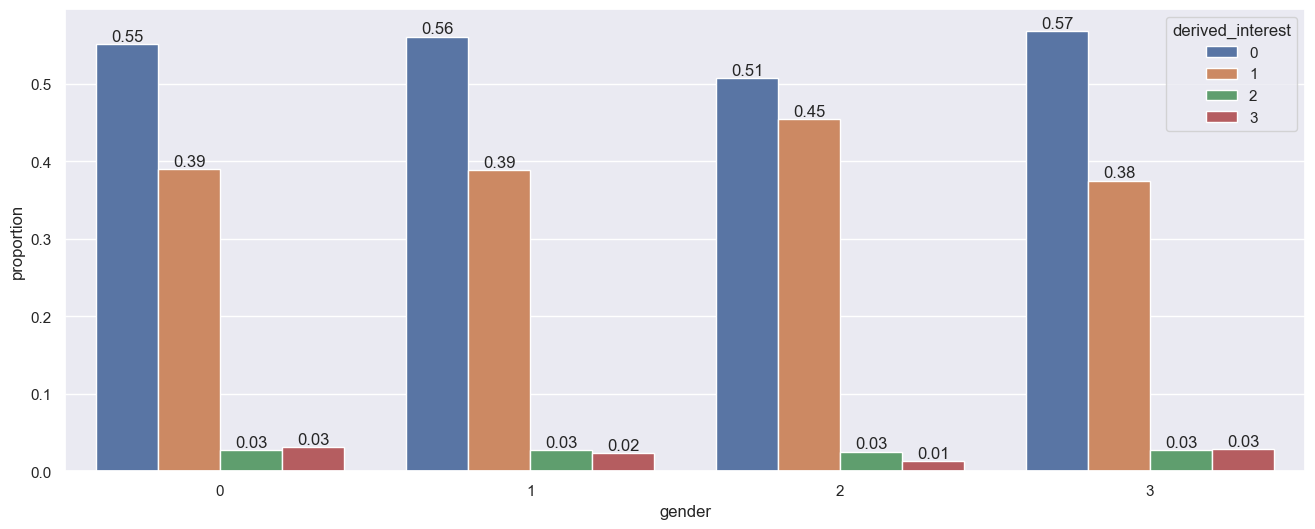

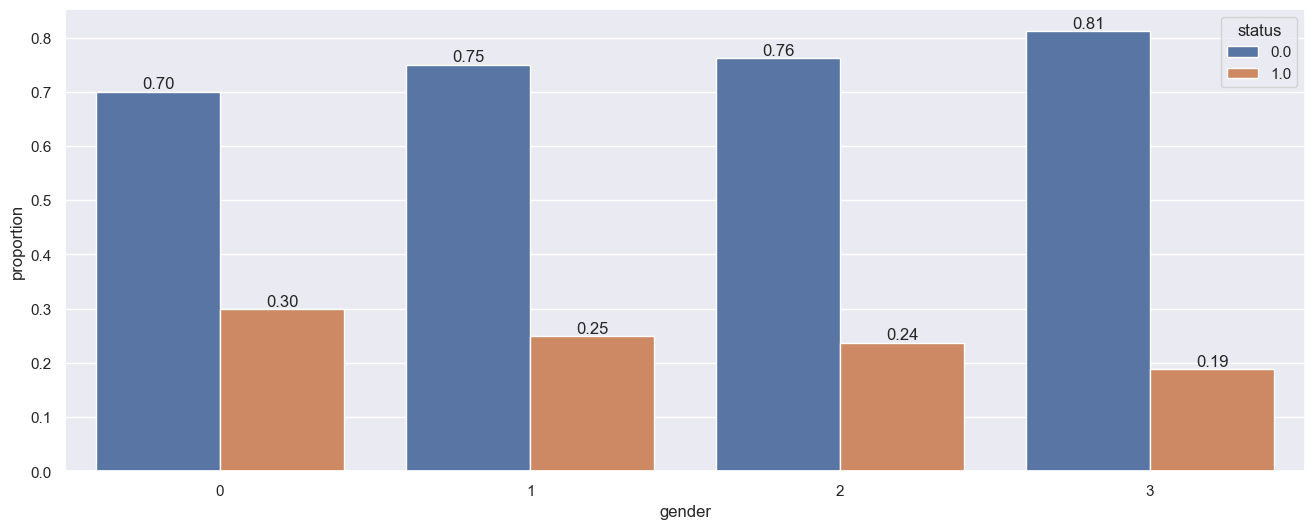

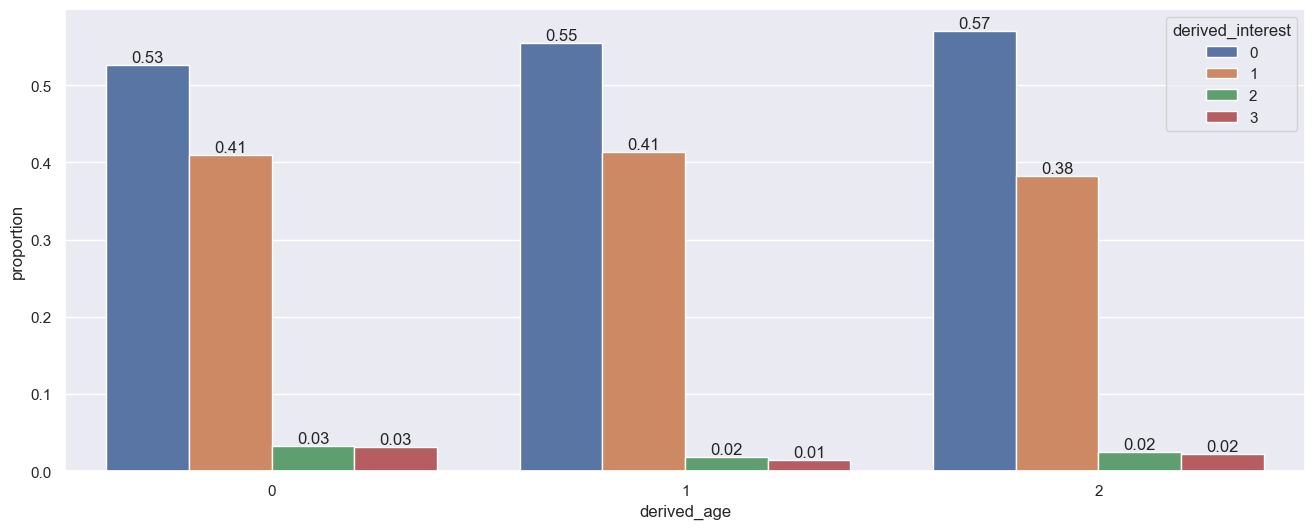

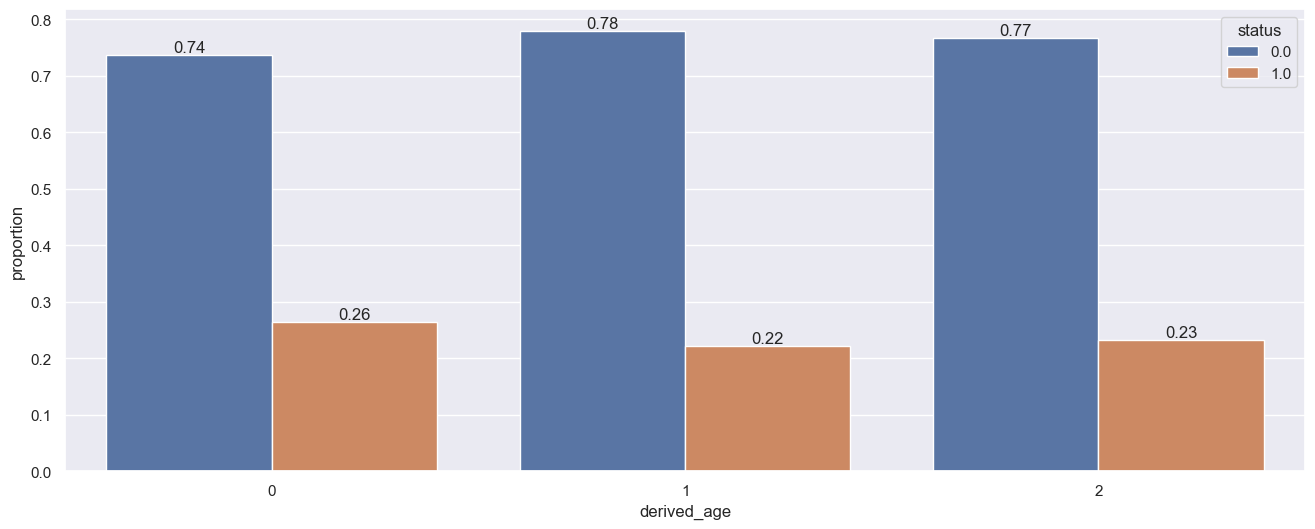

In [126]:
%matplotlib inline
# Histograms
protected = ['gender', 'derived_age']

for i in protected:
    plt.figure(figsize=(16, 6))
    sns.set_theme(style='darkgrid')

    # Calculate the proportions relative to 'derived_age'
    interest_proportions = df_numeric.groupby(i)['derived_interest'].value_counts(normalize=True).reset_index(name='proportion')

    ax = sns.barplot(data=interest_proportions, x=i, y='proportion', hue="derived_interest")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.show()


    plt.figure(figsize=(16, 6))
    sns.set_theme(style='darkgrid')

    # Calculate the proportions relative to 'derived_age'
    interest_proportions = df_numeric.groupby(i)['status'].value_counts(normalize=True).reset_index(name='proportion')

    ax = sns.barplot(data=interest_proportions, x=i, y='proportion', hue="status")
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.show()

Now that all the values were numeric, I movee to pre-processing.

In [127]:
# Convert multi-class labels into binary labels; 'derived_interest' of 3 = 'Low'
df_binary = df_numeric.copy()
df_binary['derived_interest'] = df_binary['derived_interest'].apply(lambda x: 1 if x == 3 else 0)

binary_label_dataset = BinaryLabelDataset(
    favorable_label = 1,
    unfavorable_label = 0,
    df = df_binary,
    label_names = ['derived_interest'],
    protected_attribute_names = ['gender'])

In [128]:
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binary_label_dataset)
df_transformed = dataset_transf_train.convert_to_dataframe()[0]
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14770 entries, 0 to 14769
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_amount                14770 non-null  float64
 1   rate_of_interest           14770 non-null  float64
 2   interest_rate_spread       14770 non-null  float64
 3   upfront_charges            14770 non-null  float64
 4   term                       14770 non-null  float64
 5   property_value             14770 non-null  float64
 6   income                     14770 non-null  float64
 7   credit_score               14770 non-null  float64
 8   ltv                        14770 non-null  float64
 9   status                     14770 non-null  float64
 10  dtir1                      14770 non-null  float64
 11  id                         14770 non-null  float64
 12  loan_limit                 14770 non-null  float64
 13  gender                     14770 non-null  float64


### 3.4
Next, I used the two fairness metrics identified earlier and compute the fairness metrics on the transformed dataset.

In [129]:
# Assigning baseline thresholds for each dependent variable
trans_interest_threshold = 3
trans_status_threshold = 0

# Computing SPD for transformed derived_age
trans_derived_age_privileged = 0
trans_derived_age_unprivileged = [1, 2]

# Computing SPD for transformed gender
trans_gender_privileged = 3
trans_gender_unprivileged = [0, 1, 2]

trans_spd_derived_age_interest = spd(df_transformed, 'derived_age', 'derived_interest', trans_derived_age_privileged, trans_derived_age_unprivileged, trans_interest_threshold)

trans_spd_derived_age_status = spd(df_transformed, 'derived_age', 'status', trans_derived_age_privileged, trans_derived_age_unprivileged, trans_status_threshold)

trans_spd_gender_interest = spd(df_transformed, 'gender', 'derived_interest', trans_gender_privileged, trans_gender_unprivileged, trans_interest_threshold)

trans_spd_gender_status = spd(df_transformed, 'gender', 'status', trans_gender_privileged, trans_gender_unprivileged, trans_status_threshold)

trans_di_derived_age_interest = disp_impact(df_transformed, 'derived_age', 'derived_interest', trans_derived_age_privileged, trans_derived_age_unprivileged, trans_interest_threshold)

trans_di_derived_age_status = disp_impact(df_transformed, 'derived_age', 'status', trans_derived_age_privileged, trans_derived_age_unprivileged, trans_status_threshold)

trans_di_gender_interest = disp_impact(df_transformed, 'gender', 'derived_interest', trans_gender_privileged, trans_gender_unprivileged, trans_interest_threshold)

trans_di_gender_status = disp_impact(df_transformed, 'gender', 'status', trans_gender_privileged, trans_gender_unprivileged, trans_status_threshold)

# Create a dictionary with your data
data = {
    "Original SPD": [spd_derived_age_interest, spd_derived_age_status, spd_gender_interest, spd_gender_status],
    "Transformed SPD": [trans_spd_derived_age_interest, trans_spd_derived_age_status, trans_spd_gender_interest, trans_spd_gender_status],
    "Original DI": [di_derived_age_interest, di_derived_age_status, di_gender_interest, di_gender_status],
    "Transformed DI": [trans_di_derived_age_interest, trans_di_derived_age_status, trans_di_gender_interest, trans_di_gender_status]
}

# Create a list with your index values
index = ['derived_age & derived_interest', 'derived_age & status', 'gender & derived_interest', 'gender & status']

# Create the DataFrame
df_results = pd.DataFrame(data, index=index)

# Print the DataFrame
print(df_results)

                                Original SPD  Transformed SPD  Original DI  \
derived_age & derived_interest     -0.010981         0.000000     0.649724   
derived_age & status                0.033555         0.033555     1.045567   
gender & derived_interest          -0.005726         0.000000     0.802119   
gender & status                    -0.076153        -0.076153     0.906189   

                                Transformed DI  
derived_age & derived_interest        0.000000  
derived_age & status                  1.045567  
gender & derived_interest             0.000000  
gender & status                       0.906189  


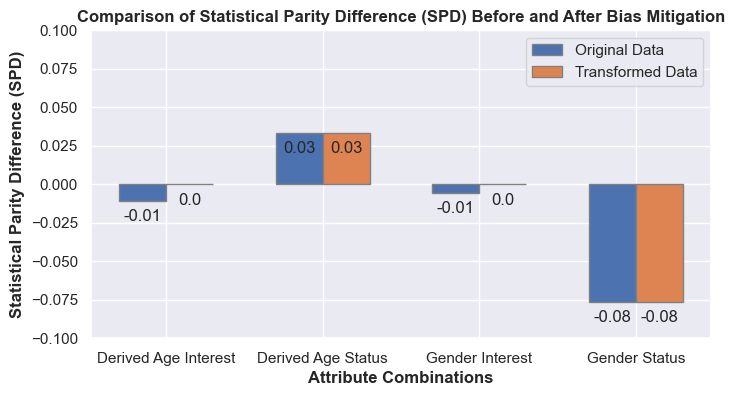

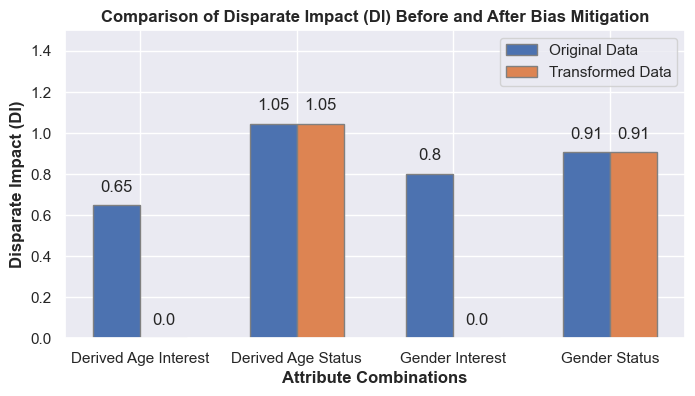

In [149]:
%matplotlib inline
# Names of the combinations
combinations = ['Derived Age Interest', 'Derived Age Status', 'Gender Interest', 'Gender Status']

# SPD metrics
original_spd_values = [spd_derived_age_interest, spd_derived_age_status, spd_gender_interest, spd_gender_status]
transformed_spd_values = [trans_spd_derived_age_interest, trans_spd_derived_age_status, trans_spd_gender_interest, trans_spd_gender_status]

# DI metrics
original_di_values = [di_derived_age_interest, di_derived_age_status, di_gender_interest, di_gender_status]
transformed_di_values = [trans_di_derived_age_interest, trans_di_derived_age_status, trans_di_gender_interest, trans_di_gender_status]

# Preparing for side-by-side bar plot
barWidth = 0.3
r1 = np.arange(len(original_spd_values))
r2 = [x + barWidth for x in r1]

# SPD plot
plt.figure(figsize=(8, 4))

bars1 = plt.bar(r1, original_spd_values, width=barWidth, edgecolor='grey', label='Original Data')
bars2 = plt.bar(r2, transformed_spd_values, width=barWidth, edgecolor='grey', label='Transformed Data')
plt.xlabel('Attribute Combinations', fontweight='bold')
plt.ylabel('Statistical Parity Difference (SPD)', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(original_spd_values))], combinations)
plt.title('Comparison of Statistical Parity Difference (SPD) Before and After Bias Mitigation', fontweight='bold')

# Adjust y-axis scale
plt.ylim(-.1, .1)  # Set y-axis scale

# Adding data labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + -0.015, round(yval, 2), ha='center', va='bottom')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + -0.015, round(yval, 2), ha='center', va='bottom')

plt.legend()
plt.show()

# DI plot
plt.figure(figsize=(8, 4))
bars1 = plt.bar(r1, original_di_values, width=barWidth, edgecolor='grey', label='Original Data')
bars2 = plt.bar(r2, transformed_di_values, width=barWidth, edgecolor='grey', label='Transformed Data')
plt.xlabel('Attribute Combinations', fontweight='bold')
plt.ylabel('Disparate Impact (DI)', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(original_di_values))], combinations)
plt.title('Comparison of Disparate Impact (DI) Before and After Bias Mitigation', fontweight='bold')

# Adjust y-axis scale
plt.ylim(0, 1.5)  # Set y-axis scale

# Adding data labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

plt.legend()
plt.show()

The transformed dataset mitigated bias for the 'derived_interest' column concerning both 'derived_age' and 'gender' - exactly as anticipated! One step closer to using this dataset for AI training.